# Compute the classification accuracy

In [1]:
#import os
from typing import List, DefaultDict
from collections import defaultdict
import pandas as pd
import numpy as np
from  scipy.signal import correlate2d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
# from numpy.linalg import norm
# import matplotlib
from matplotlib import pyplot as plt
from clearn.experiments.experiment import Experiment, load_trained_model, get_model, get_train_val_iterator, MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST
from clearn.dao.dao_factory import get_dao

import tensorflow as tf
from clearn.utils.data_loader import TrainValDataIterator, DataIterator
from clearn.utils.data_loader import load_images
#from clearn.utils.utils import get_latent_vector_column, show_all_variables, get_pmf_y_given_z
from clearn.config.common_path import get_encoded_csv_file
from clearn.models.classify.classifier import ClassifierModel
from clearn.config import ExperimentConfig
#from clearn.analysis.cluster_utils import plot_features, trace_dim
from matplotlib import pyplot  as  plt

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

# Experiment Parameters

In [2]:

z_dim = 10
run_id = 41
experiment_name = "semi_supervised_classification"
ROOT_PATH= "/Users/sunilv/concept_learning_exp"
num_units=[64, 128, 32]
#num_units = [16, 32, 8]

create_split = False
num_cluster_config=ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW

exp_config = ExperimentConfig(root_path=ROOT_PATH,
                               num_decoder_layer=4,
                               z_dim=z_dim,
                               num_units=num_units,
                               num_cluster_config=num_cluster_config,
                               confidence_decay_factor=5,
                               beta=5,
                               supervise_weight=150,
                               dataset_name="mnist",
                               split_name="Split_1",
                               model_name="VAE",
                               batch_size=64,
                               eval_interval_in_epochs=1,
                               name=experiment_name,
                               num_val_samples=128,
                               total_training_samples=60000,
                               manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                               reconstruction_weight=1,
                               activation_hidden_layer="RELU",
                               activation_output_layer="SIGMOID")
exp_config.check_and_create_directories(run_id)
BATCH_SIZE = exp_config.BATCH_SIZE
DATASET_NAME = exp_config.dataset_name

cluster_column_name ="cluster_level_1"
cluster_column_name_2 ="cluster_level_2"
cluster_column_name_3 ="cluster_level_3"
dao = get_dao(exp_config.dataset_name, exp_config.split_name, exp_config.num_val_samples)

In [3]:
train_val_data_iterator = get_train_val_iterator(create_split=create_split,
                                                 dao= dao,
                                                 exp_config= exp_config,
                                                 num_epochs_completed=0,
                                                 split_name=exp_config.split_name)

Warning /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_32_128_64_10_ELBOW_41/analysis/manual_annotation_epoch_-1.0.csv path does not exist. Creating random prior with uniform distribution


# Load Trained Model

In [4]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print(f"Number of steps completed={num_steps_completed}")
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print(f"Number of epochs completed {epochs_completed}")
tf.reset_default_graph()




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.



 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-4675
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_32_128_64_10_ELBOW_41/trained_models/SemiSupervisedClassifierMnist.model-4675
 [*] Success to read SemiSupervisedClassifierMnist.model-4675
 [*]

# Load Validation images

In [5]:
val_images, val_labels, manual_annotation_np = load_images(exp_config,
                                                           train_val_data_iterator,
                                                           "val")
unique_labels = train_val_data_iterator.get_unique_labels()
num_batches = val_images.shape[0] / exp_config.BATCH_SIZE
val_labels= np.argwhere(val_labels == 1)[:,1]

In [6]:
def classify_images(model, images, batch_size, z_dim):
    num_images = images.shape[0]
    num_batches = num_images // batch_size
    batch_num = 0
    logits = np.zeros([len(images), z_dim])
    print(logits.shape)
    print(logits[batch_num * batch_size: (batch_num + 1) * batch_size].shape)
    if num_batches >= 1:
        # Run for first batch to get the dimensions
        batch_num = 0
        _logits = model.classify(images[batch_num * batch_size: (batch_num + 1) * batch_size])[0]
        print(_logits.shape)
        logits[batch_num * batch_size: (batch_num + 1) * batch_size] = _logits
 
        for batch_num in range(1, num_batches):
            _logits = model.classify(images[batch_num * batch_size: (batch_num + 1) * batch_size])[0]
            logits[batch_num * batch_size: (batch_num + 1) * batch_size] = _logits
 
    left_out = num_images % batch_size
    if left_out > 0:
        # TODO remove this hard-coding
        feature_dimension = [batch_size, 28, 28, 1]
        last_batch = np.zeros(feature_dimension)
        last_batch[0:left_out] = images[num_batches * batch_size:]
        _logits = model.classify(last_batch)[0]
        logits[num_batches * batch_size:] = _logits[0:left_out]

    return logits


## Classify images

In [7]:
model = None
tf.reset_default_graph()
val_latent_vectors_by_label = []
val_mu_by_label = []
val_sigma_by_label = []

reconstructed_images = []
images_by_label = []
val_decoder_features = defaultdict(list)
val_encoder_features = defaultdict(list)

reconstructed_images_from_l3 = []

with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
        logits = classify_images(model, val_images, exp_config.BATCH_SIZE, exp_config.Z_DIM)

tf.reset_default_graph()

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-4675
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_32_128_64_10_ELBOW_41/trained_models/SemiSupervisedClassifierMnist.model-4675
 [*] Success to read SemiSupervisedClassifierMnist.model-4675
 [*] Load SUCCESS
Number of steps completed=4675
Number of epochs completed 5.0
(128, 10)
(64, 10)
(64, 10)


In [8]:
from scipy.special import softmax
pred = softmax(logits)
print(pred.shape)

(128, 10)


In [9]:
pred_labels = np.argmax(pred,axis=1)
print(pred_labels.shape)

(128,)


In [10]:
print(val_labels.shape)

(128,)


In [11]:
from sklearn.metrics import accuracy_score
print(accuracy_score(val_labels, pred_labels))

0.7734375


In [12]:
print(val_labels)

[0 3 2 6 1 7 7 1 6 0 1 9 1 5 0 9 3 8 3 2 4 4 5 9 9 4 5 3 4 7 5 2 7 4 2 9 7
 9 9 7 5 1 2 5 4 5 9 4 6 8 9 3 2 1 3 1 6 3 7 0 5 6 3 3 8 9 4 0 6 0 2 8 8 8
 2 2 1 2 2 6 9 1 0 5 2 6 8 3 6 7 7 3 8 7 0 8 3 1 9 9 6 8 0 7 4 5 0 0 8 1 2
 3 7 6 1 0 4 0 4 6 1 6 4 7 5 8 1 5]


In [13]:
print(pred_labels)

[0 3 8 6 1 7 7 1 6 0 1 4 1 5 0 9 3 8 3 2 9 4 5 9 9 9 1 8 4 7 5 2 7 9 2 4 7
 9 9 7 9 1 2 6 9 5 9 4 6 8 7 3 2 1 8 1 2 3 4 0 3 6 8 8 8 9 9 0 6 0 2 8 8 8
 2 2 1 8 2 6 9 1 0 3 2 6 8 3 6 7 7 3 8 7 0 8 3 1 4 9 3 8 0 7 4 6 0 0 8 1 2
 4 7 6 1 0 9 0 9 6 1 6 4 7 3 8 1 3]


# Compute accuracy on test data

In [14]:
test_data_location = exp_config.DATASET_ROOT_PATH + "/test/"
test_data_iterator = DataIterator(dataset_path=exp_config.DATASET_ROOT_PATH,
                                  batch_size=exp_config.BATCH_SIZE,
                                  dao=dao)

In [15]:
val_images, val_labels, manual_annotation_np = load_images(exp_config,
                                                           test_data_iterator,
                                                           "test"
                                                          )
unique_labels = test_data_iterator.get_unique_labels()
num_batches = val_images.shape[0] / exp_config.BATCH_SIZE
val_labels= np.argwhere(val_labels == 1)[:,1]

In [16]:
model = None
tf.reset_default_graph()
val_latent_vectors_by_label = []
val_mu_by_label = []
val_sigma_by_label = []

reconstructed_images = []
images_by_label = []
val_decoder_features = defaultdict(list)
val_encoder_features = defaultdict(list)

reconstructed_images_from_l3 = []

with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
        logits = classify_images(model, val_images, exp_config.BATCH_SIZE, exp_config.Z_DIM)

tf.reset_default_graph()

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-4675
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_32_128_64_10_ELBOW_41/trained_models/SemiSupervisedClassifierMnist.model-4675
 [*] Success to read SemiSupervisedClassifierMnist.model-4675
 [*] Load SUCCESS
Number of steps completed=4675
Number of epochs completed 5.0
(9984, 10)
(64, 10)
(64, 10)


In [17]:
from  scipy.special import softmax
pred = softmax(logits)
print(pred.shape)
pred_labels = np.argmax(pred,axis=1)
print(pred_labels.shape)

(9984, 10)
(9984,)


In [18]:
from sklearn.metrics import accuracy_score
print(accuracy_score(val_labels, pred_labels))

0.7455929487179487


In [19]:
# accuracy after epoch 1

In [23]:
run_id_dict = dict()
for run_id in [41,42]:
    exp_config.check_and_create_directories(run_id)
    model = None
    tf.reset_default_graph()
    val_latent_vectors_by_label = []
    val_mu_by_label = []
    val_sigma_by_label = []

    reconstructed_images = []
    images_by_label = []
    val_decoder_features = defaultdict(list)
    val_encoder_features = defaultdict(list)

    reconstructed_images_from_l3 = []
    accuracy_dict = dict()
    for check_point_epochs in range(1, 5):
        with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
            model = get_model(dao = dao,
                              exp_config=exp_config,
                              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                              num_epochs=1,
                              sess=sess,
                              test_data_iterator=None,
                              train_val_data_iterator=None,
                              check_point_epochs=check_point_epochs
                             )
            num_steps_completed = model.counter
            print("Number of steps completed={}".format(num_steps_completed))
            num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
            epochs_completed = num_steps_completed // num_batches
            print("Number of epochs completed {}".format(epochs_completed))
            logits = classify_images(model, val_images, exp_config.BATCH_SIZE, exp_config.Z_DIM)

        tf.reset_default_graph()

        pred = softmax(logits)
        print(pred.shape)
        pred_labels = np.argmax(pred,axis=1)
        print(pred_labels.shape)
        _acc = accuracy_score(val_labels, pred_labels)
        print(_acc)
        accuracy_dict[check_point_epochs] = _acc
    run_id_dict[run_id] = accuracy_dict
    


INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
num_training_samples 935
ckpt_name SemiSupervisedClassifierMnist.model-936
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_32_128_64_10_ELBOW_41/trained_models/SemiSupervisedClassifierMnist.model-936
 [*] Success to read SemiSupervisedClassifierMnist.model-936
 [*] Load SUCCESS
Number of steps completed=936
Number of epochs completed 1.0
(9984, 10)
(64, 10)
(64, 10)
(9984, 10)
(9984,)
0.07421875
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is il

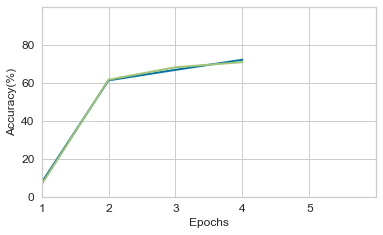

In [25]:
import os

plot_filename = "classification_accuracy.pdf"

plt.figure(figsize=(6, 3.5))

for run_id in [41, 42]:
    accuracy_dict = run_id_dict[run_id]
    plt.plot(list(accuracy_dict.keys()), np.asarray(list(accuracy_dict.values())) * 100, lw=2)
axis_font = {'fontname':'Arial', 'size':'12'}

plt.xlabel("Epochs", **axis_font)
plt.ylabel("Accuracy(%)", **axis_font)

plt.xlim(1,6)
plt.xticks(ticks = [i for i in range(1,6,1)], labels = [i for i in range(1,6,1)], **axis_font)
plt.ylim(0,100)
plt.yticks(ticks=[i for i in range(0, 100, 20)], **axis_font)

plt.savefig(os.path.join("/Users/sunilv/gitprojects/concept_learning/docs/uai2021/", plot_filename), bbox="tight") 

    #plt.plot(list(accuracy_dict_unsupervised.keys()), list(accuracy_dict_unsupervised.values()))

In [19]:
experiment_name = "Experiment_1"
z_dim = 10
run_id = 0
exp_config_unsupervised = ExperimentConfig(root_path="/Users/sunilv/concept_learning_exp",
                              num_decoder_layer=4,
                              z_dim=z_dim,
                              num_units=[64, 128, 32],
                              num_cluster_config=None,
                              confidence_decay_factor=5,
                              beta=5,
                              supervise_weight=150,
                              dataset_name="mnist",
                              split_name="Split_1",
                              model_name="VAE",
                              batch_size=64,
                              eval_interval=300,
                              name=experiment_name,
                              num_val_samples=128,
                              total_training_samples=60000,
                              manual_labels_config=TrainValDataIterator.USE_CLUSTER_CENTER,
                              reconstruction_weight=1,
                              activation_hidden_layer="RELU",
                              activation_output_layer="SIGMOID"
                              )
exp_config_unsupervised.check_and_create_directories(run_id, False)

True

In [20]:
model = None
tf.reset_default_graph()
val_latent_vectors_by_label = []
val_mu_by_label = []
val_sigma_by_label = []

reconstructed_images = []
images_by_label = []
val_decoder_features = defaultdict(list)
val_encoder_features = defaultdict(list)

reconstructed_images_from_l3 = []
accuracy_dict_unsupervised = dict()
for check_point_epochs in range(1, 7):
    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
            model = ClassifierModel(exp_config_unsupervised,
                                    sess,
                                    epoch=1,
                                    batch_size=exp_config_unsupervised.BATCH_SIZE,
                                    z_dim=z_dim,
                                    dataset_name=exp_config_unsupervised.dataset_name,
                                    beta = exp_config_unsupervised.beta,
                                    num_units_in_layer=exp_config_unsupervised.num_units,
                                    log_dir=exp_config_unsupervised.LOG_PATH,
                                    checkpoint_dir=exp_config_unsupervised.TRAINED_MODELS_PATH,
                                    result_dir=exp_config_unsupervised.PREDICTION_RESULTS_PATH,
                                    check_point_epochs=check_point_epochs
                                   )
            num_steps_completed = model.counter
            print("Number of steps completed={}".format(num_steps_completed))
            num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
            epochs_completed = num_steps_completed // num_batches
            print("Number of epochs completed {}".format(epochs_completed))
            logits = classify_images(model, val_images, exp_config.BATCH_SIZE, exp_config.Z_DIM)

    tf.reset_default_graph()

    pred = softmax(logits)
    print(pred.shape)
    pred_labels = np.argmax(pred,axis=1)
    print(pred_labels.shape)
    _acc = accuracy_score(val_labels, pred_labels)
    print(_acc)
    accuracy_dict_unsupervised[check_point_epochs] = _acc


INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-936
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/Experiment_1/Exp_20_32_128_64_10_0/trained_models/ClassifierModel.model-936
 [*] Success to read ClassifierModel.model-936
 [*] Load SUCCESS
Number of steps completed=936
Number of epochs completed 1.0
(9984, 10)
(64, 10)
(64, 10)
(9984, 10)
(9984,)
0.09985977564102565
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Los

In [28]:
check_point_epochs = 6
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = ClassifierModel(exp_config,
                                sess,
                                epoch=1,
                                batch_size=exp_config.BATCH_SIZE,
                                z_dim=z_dim,
                                dataset_name=exp_config.dataset_name,
                                beta = exp_config.beta,
                                num_units_in_layer=exp_config.num_units,
                                log_dir=exp_config.LOG_PATH,
                                checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
                                result_dir=exp_config.PREDICTION_RESULTS_PATH,
                                check_point_epochs=check_point_epochs
                               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
        logits = classify_images(model, val_images, exp_config.BATCH_SIZE, exp_config.Z_DIM)

pred = softmax(logits)
print(pred.shape)
pred_labels = np.argmax(pred,axis=1)
print(pred_labels.shape)
print(accuracy_score(val_labels, pred_labels))


INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-5611


ValueError: The passed save_path is not a valid checkpoint: /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_10/trained_models/ClassifierModel.model-5611

In [20]:
pred = softmax(logits)
print(pred.shape)
pred_labels = np.argmax(pred,axis=1)
print(pred_labels.shape)
print(accuracy_score(val_labels, pred_labels))

(9984, 10)
(9984,)
0.09134615384615384


In [ ]:
create_split = False
z_dim = 10
experiment_name = "supervised_classification"
num_epochs = 10
num_cluster_config = ExperimentConfig.NUM_CLUSTERS_CONFIG_TWO_TIMES_ELBOW
run_id = 1

In [ ]:
model, exp_config = load_trained_model(experiment_name,
                         z_dim,
                         run_id,
                         num_cluster_config,
                         manual_labels_config=TrainValDataIterator.USE_ACTUAL,
                         supervise_weight=1,
                         beta=0,
                         reconstruction_weight=0,
                         model_type=MODEL_TYPE_SUPERVISED_CLASSIFIER)

In [ ]:
model = None
tf.reset_default_graph()
val_latent_vectors_by_label = []
val_mu_by_label = []
val_sigma_by_label = []

reconstructed_images = []
images_by_label = []
val_decoder_features = defaultdict(list)
val_encoder_features = defaultdict(list)

reconstructed_images_from_l3 = []

with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = ClassifierModel(exp_config,
                                sess,
                                epoch=1,
                                batch_size=exp_config.BATCH_SIZE,
                                z_dim=z_dim,
                                dataset_name=exp_config.dataset_name,
                                beta = exp_config.beta,
                                num_units_in_layer=exp_config.num_units,
                                log_dir=exp_config.LOG_PATH,
                                checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
                                result_dir=exp_config.PREDICTION_RESULTS_PATH
                               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
        logits = classify_images(model, val_images, exp_config.BATCH_SIZE, exp_config.Z_DIM)

tf.reset_default_graph()

In [ ]:
from scipy.special import softmax
pred = softmax(logits)
print(pred.shape)

In [ ]:
pred_labels = np.argmax(pred,axis=1)
print(pred_labels.shape)

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(val_labels, pred_labels))